# The SPE1 model (gas injection)
[Odeh, A.S. 1981. Comparison of Solutions to a Three-Dimensional Black-Oil
Reservoir Simulation Problem. J Pet Technol 33 (1): 13–25.
SPE-9723-PA](http://dx.doi.org/10.2118/9723-PA)

In [1]:
using Jutul, JutulDarcy, GLMakie, DelimitedFiles
spe1_dir = JutulDarcy.GeoEnergyIO.test_input_file_path("SPE1")
case = setup_case_from_data_file(joinpath(spe1_dir, "SPE1.DATA"))
ws, states = simulate_reservoir(case, output_substates = true)

Simulating 9 years, 51.83 weeks as 120 report steps   2%  ETA: 0:00:26
  Progress:  Solving step 2/120 (1.62% of time interval complete)


Simulating 9 years, 51.83 weeks as 120 report steps  20%  ETA: 0:00:02
  Progress:  Solving step 24/120 (20.00% of time interval complete)


Simulating 9 years, 51.83 weeks as 120 report steps  39%  ETA: 0:00:01
  Progress:  Solving step 47/120 (39.15% of time interval complete)


Simulating 9 years, 51.83 weeks as 120 report steps  60%  ETA: 0:00:01
  Progress:  Solving step 72/120 (60.00% of time interval complete)


Simulating 9 years, 51.83 weeks as 120 report steps  79%  ETA: 0:00:00
  Progress:  Solving step 96/120 (80.00% of time interval complete)


Simulating 9 years, 51.83 weeks as 120 report steps 100% Time: 0:00:00
  Progress:  Solved step 120/120
  Stats:     394 iterations in 933.28 ms (2.37 ms each)
╭────────────────┬───────────┬───────────────┬──────────╮
│ Iteration type │  Avg/step │  Avg/ministep │    Total │
│                │ 12

ReservoirSimResult with 127 entries:

  wells (2 present):
    :INJ
    :PROD
    Results per well:
       :wrat => Vector{Float64} of size (127,)
       :Aqueous_mass_rate => Vector{Float64} of size (127,)
       :orat => Vector{Float64} of size (127,)
       :bhp => Vector{Float64} of size (127,)
       :lrat => Vector{Float64} of size (127,)
       :mass_rate => Vector{Float64} of size (127,)
       :rate => Vector{Float64} of size (127,)
       :Vapor_mass_rate => Vector{Float64} of size (127,)
       :control => Vector{Symbol} of size (127,)
       :Liquid_mass_rate => Vector{Float64} of size (127,)
       :grat => Vector{Float64} of size (127,)

  states (Vector with 127 entries, reservoir variables for each state)
    :BlackOilUnknown => Vector{BlackOilX{Float64}} of size (300,)
    :Saturations => Matrix{Float64} of size (3, 300)
    :Pressure => Vector{Float64} of size (300,)
    :Rs => Vector{Float64} of size (300,)
    :ImmiscibleSaturation => Vector{Float64} of size (300,)


# Load reference

In [2]:
csv_path = joinpath(spe1_dir, "REFERENCE.CSV")
data, header = readdlm(csv_path, ',', header = true)
time_ref = data[:, 1]
time_jutul = deepcopy(ws.time)
wells = deepcopy(ws.wells)
wnames = collect(keys(wells))
nw = length(wnames)
day = si_unit(:day)
cmap = :tableau_hue_circle

inj = Symbol[]
prod = Symbol[]
for (wellname, well) in pairs(wells)
    qts = well[:wrat] + well[:orat] + well[:grat]
    if sum(qts) > 0
        push!(inj, wellname)
    else
        push!(prod, wellname)
    end
end

function plot_well_comparison(response, well_names, reponse_name = "$response")
    fig = Figure(size = (1000, 400))
    if response == :bhp
        ys = 1/si_unit(:bar)
        yl = "Bottom hole pressure / Bar"
    elseif response == :wrat
        ys = si_unit(:day)
        yl = "Surface water rate / m³/day"
    elseif response == :grat
        ys = si_unit(:day)/1e6
        yl = "Surface gas rate / 10⁶ m³/day"
    elseif response == :orat
        ys = si_unit(:day)/(1000*si_unit(:stb))
        yl = "Surface oil rate / 10³ stb/day"
    else
        error("$response not ready.")
    end
    welltypes = []
    ax = Axis(fig[1:4, 1], xlabel = "Time / days", ylabel = yl)
    i = 1
    linehandles = []
    linelabels = []
    for well_name in well_names
        well = wells[well_name]
        label_in_csv = "$well_name:$response"
        ref_pos = findfirst(x -> x == label_in_csv, vec(header))
        qoi = copy(well[response]).*ys
        qoi_ref = data[:, ref_pos].*ys
        tot_rate = copy(well[:rate])
        @. qoi[tot_rate == 0] = NaN
        grat_ref = data[:, findfirst(x -> x == "$well_name:grat", vec(header))]
        orat_ref = data[:, findfirst(x -> x == "$well_name:orat", vec(header))]
        wrat_ref = data[:, findfirst(x -> x == "$well_name:wrat", vec(header))]
        tot_rate_ref = grat_ref + orat_ref + wrat_ref
        @. qoi_ref[tot_rate_ref == 0] = NaN
        crange = (1, max(length(well_names), 2))
        lh = lines!(ax, time_jutul./day, abs.(qoi),
            color = i,
            colorrange = crange,
            label = "$well_name", colormap = cmap
        )
        push!(linehandles, lh)
        push!(linelabels, "$well_name")
        lines!(ax, time_ref./day, abs.(qoi_ref),
            color = i,
            colorrange = crange,
            linestyle = :dash,
            colormap = cmap
        )
        i += 1
    end
    l1 = LineElement(color = :black, linestyle = nothing)
    l2 = LineElement(color = :black, linestyle = :dash)

    Legend(fig[1:3, 2], linehandles, linelabels, nbanks = 3)
    Legend(fig[4, 2], [l1, l2], ["JutulDarcy.jl", "OPM Flow"])
    fig
end

plot_well_comparison (generic function with 2 methods)

## Injector BHP

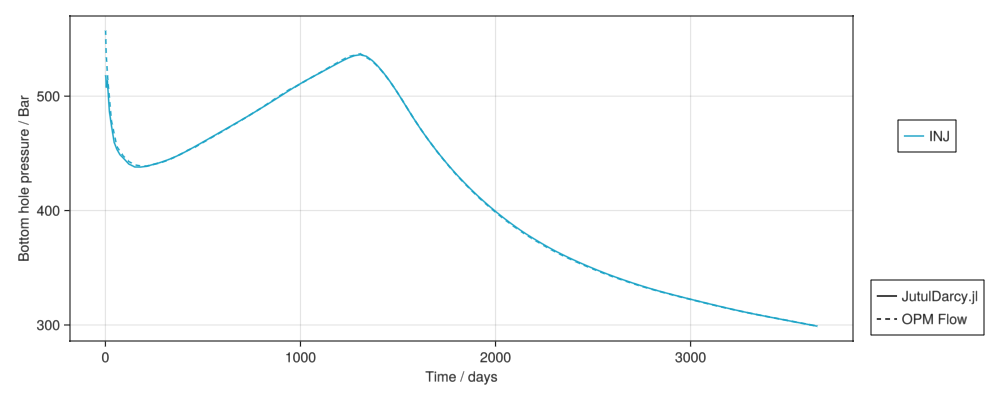

In [3]:
plot_well_comparison(:bhp, inj, "Bottom hole pressure")

## Producer BHP

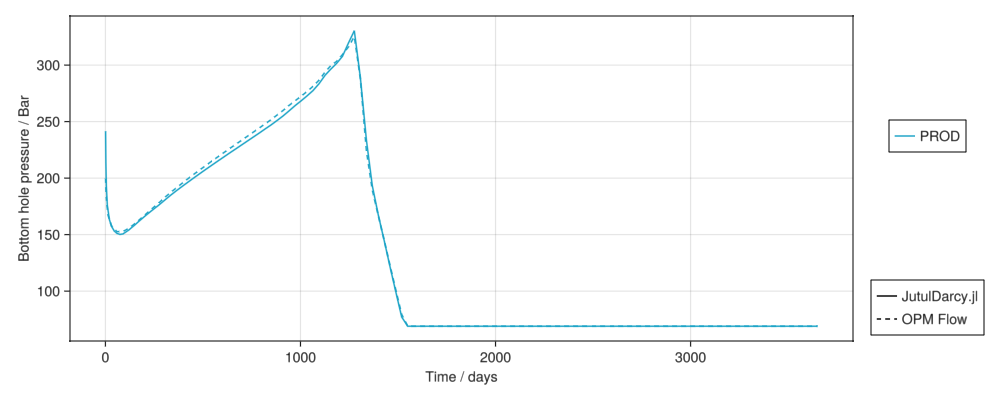

In [4]:
plot_well_comparison(:bhp, prod, "Bottom hole pressure")

## Producer oil rate

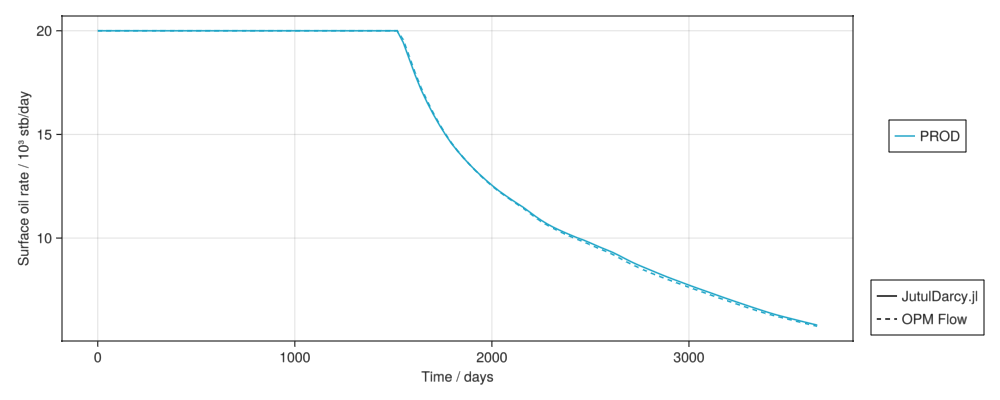

In [5]:
plot_well_comparison(:orat, prod, "Oil surface rate")

## Producer gas rate

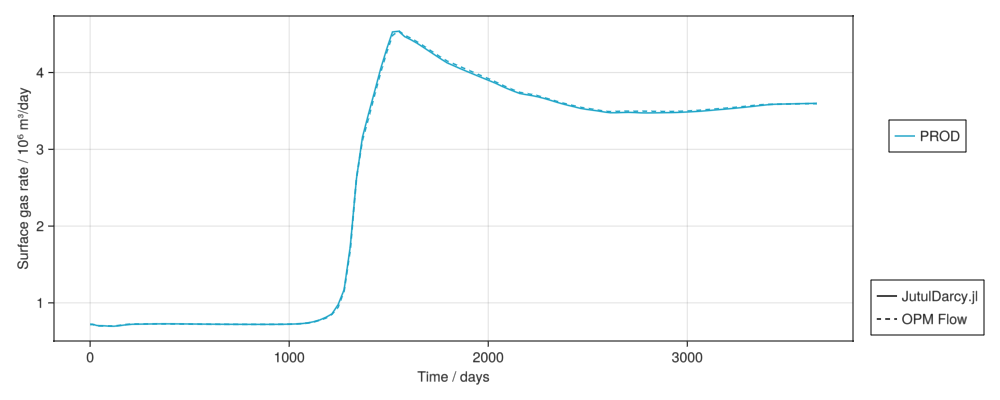

In [6]:
plot_well_comparison(:grat, prod, "Gas surface rate")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*